## Symphony of Data: A comprehensive Analysis of Artist Collarboration and Lyrical content in the Top music charts 
### Group 14 

> Github repository: https://github.com/LivDreyer/CSS24.git



> Contribution: The workload was distributed equally between all members of the group. 

![Crowd](crowd.png)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import json
import networkx as nx
import netwulf as nu
from networkx.readwrite import json_graph
import random
import pandas as pd
import ast
from collections import Counter
from wordcloud import WordCloud
import re
import requests
import time
from tqdm import tqdm
import logging
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from bs4 import BeautifulSoup
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Table of Contents

* [1. Motivation](#motivation)
    * [1.1 Datasets and motivation](#datasets)
    * [1.2 Goal for the end user's experience](#goaluser)  
* [2. Data construction and Basic Statistics](#datacons)
    * [2.1 Data collection from the Spotify API](#spotify)
    * [2.2 Data collection from the Genius API](#textdata)
        * [2.2.1 Creating data for textual analysis](#textdata_create)
        * [2.2.2 Basic Statistics of textual data](#basic_stats_text)
    * [2.3 Artist collaboration network data](#networkdata)
        * [2.3.1 Preprocessing and cleaning](#networkpreclean)
        * [2.3.2 Creation of network](#creation_of_network)
        * [2.3.3 Basic statistics - network data](#basic_stats_network) 
* [3. Data analysis](#data_analysis)
    * [3.1 Network analysis](#network_analysis)
        * [3.1.1 Degree distribution](#degree_distribution)
        * [3.1.2 Assortivity](#assortivity)
        * [3.1.3 Communities](#communities)
    * [3.2 Textual analysis](#text_analysis)
        * [3.2.1 Motivation](#motivation_text)
        * [3.2.1 TF-IDF](#TF_IDF)
        * [3.2.2 Wordclouds](#wordclouds)
* [4. Discussion](#discussion)
* [5. References](#references)


## 1. Motivation <a class="anchor" id="motivation"></a>

### 1.1 What are our datasets and what is our motivation for choosing these? <a class="anchor" id="datasets"></a>

Since the 1990's we have seen a 30% increase in collaborations between artists in the music industry [3], and according to the "Billboard year-end hot singels of 2023"[4], 40% of the top 10 songs are by more than 1 artist.

This project aims to answer the research question: "What is the relationship between artist collaboration patterns, popularity, and lyrical expression of genre themes?". 

To answer this question, we decided to center our network analysis around the worlds largest music streaming service: Spotify. Given our project's focus on artist popularity, using a platform such as Spotify for insights is logical. With streaming services contributing to 84% of the music industry's revenue, and Spotify holding a dominant market share of 30.5% [1], it offers a comprehensive insight to artist popularity. This project utilizes the [Spotify API](https://developer.spotify.com/documentation/web-api) to gain insight into artist collaborations and the popularity of artists.

For the textual analysis [Genius](https://genius.com), among others, serve as an "online music encyclopidia" [2]. Although the textual analysis in this project could utilize a variety of song lyric API's, [Genius' API](https://docs.genius.com) offers the ability for artists and users to annotate lyrics, making it an interesting choice for analyses in the future. 

This projects takes starting point in the Kaggle dataset ["US Top 10K Artists and Their Popular Songs"](https://www.kaggle.com/datasets/spoorthiuk/us-top-10k-artists-and-their-popular-songs). The dataset, created by Spoorthi Uday Karakaraddi, was collected using the Spotify API and features several attributes of the top 10k artists in the US in 2023. It serves as the foundation for constructing the datasets used for network analysis, and the textual analysis. 

[1] https://explodingtopics.com/blog/music-streaming-stats

[2] https://en.wikipedia.org/wiki/Genius_(company)

[3] https://www.economist.com/graphic-detail/2018/02/02/popular-music-is-more-collaborative-than-ever

[4] https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_2023


### 1.2 Our goal for the end user's experience <a class="anchor" id="goaluser"></a>

Text

## 2. Data construction and basic statistics <a class="anchor" id="datacons"></a>

Since this project is working with API's, we are constructing the datasets from API data taking our starting point, as mentioned, in the Kaggle dataset ["US Top 10K Artists and Their Popular Songs"](https://www.kaggle.com/datasets/spoorthiuk/us-top-10k-artists-and-their-popular-songs). To provide a clear explanation of our course of action, this data section is divided into three parts: data collection from the Spotify API, data collection from the Genius API used for textual analysis, and lastly the preprocessing of data for the network and subqequent creation of it. For clarity, each block of code will be preceded with the name of the resulting csv-file. 


> **Note:** In this project, a collaboration between two artists is considered one if an artist have a featuring artist on their songs. An example could be the artist "Rihanna". On her song titled "Consideration", we see the artist "SZA" is featured, which in this project will be considered a collaboration. To explore artists collaboration patterns, we used the "US Top 10K Artists and Their Popular Songs"-dataset to create our first list of artists.  

### 2.1 Data collection from the Spotify API <a class="anchor" id="spotify"></a>

### Data Description
In this project, we utilize datasets acquired from the Spotify API, which includes detailed information about artists and songs. Below, we describe the attributes used in these datasets:

#### Artist Attributes
- **Followers**: Information about the number of Spotify users who follow the artist. This number indicates the artist's fanbase size and can be an indicator of their popularity.
- **Genres**: Genres associated with the artist. These genres help classify the artist's music and can affect discovery on the platform.
- **ID**: Unique identifier for the artist on Spotify. This ID is essential for querying specific data about the artist from the API.
- **Name**: The artist's name as it appears on Spotify. This is the primary way users find and interact with artists on the platform.
- **Popularity**: A score between 0 and 100 that measures the artist's popularity on Spotify. This score is calculated from the popularity of all the artist's tracks.
- **URI**: Spotify URI that provides a direct link to access the artist on the platform.

#### Song Attributes
- **Song ID**: Unique identifier for the song on Spotify.
- **Song Name**: The official title of the song as listed on Spotify.
- **Artist**: The name of the primary artist associated with the song. This does not automatically include featured artists unless noted in the song's metadata.
- **Featured Artists**: This attribute is created by parsing the "feat" or "ft." notation in the song title. It identifies additional artists who contributed to the track but may not be listed as the primary artist. This attribute is manually extracted and added to the dataset to highlight these collaborations.

The first query from the Spotify API consisted of retrieving the top 10 tracks of each artist from the Kaggle dataset to reveal possible featuring artists. Due to a rate limit of 5000 requests per day on queries from the Spotify API, with the API key being valid for only one hour, only the top 4250 artists, ranked by Spotify's measure of popularity, from the Kaggle dataset was used. This resulted in a dataframe of the Song ID, Song Name, Main Artist, Featured Artist(s) of the song, and the Genre of the Artist. 

##### Complete_Songs_with_Artists_and_Features.csv <a class="anchor" id="CompleteSongs"></a>

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Spotify API credentials
client_id = '#'  
client_secret = '#'  

def refresh_token():
    """ Refresh the Spotify API token. """
    url = 'https://accounts.spotify.com/api/token'
    payload = {'grant_type': 'client_credentials'}
    response = requests.post(url, auth=(client_id, client_secret), data=payload)
    if response.status_code == 200:
        new_token = response.json()['access_token']
        logging.info("Token refreshed successfully.")
        return new_token
    else:
        logging.error(f"Failed to refresh token: {response.text}")
        raise Exception("Failed to refresh token")

# Initial token
token = refresh_token()
headers = {'Authorization': f'Bearer {token}'}

def get_top_tracks(artist_id, retry_count=0):
    """ Fetch top tracks for a given artist ID from Spotify, handling rate limits dynamically. """
    global headers
    top_tracks_url = f"https://api.spotify.com/v1/artists/{artist_id}/top-tracks?country=US"
    response = requests.get(top_tracks_url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        return [(track['id'], track['name'], [artist['name'] for artist in track['artists']]) for track in data.get('tracks', [])]
    elif response.status_code == 429:
        retry_after = int(response.headers.get("Retry-After", 30))
        wait_time = min(retry_after, 30)  # Cap at 30 seconds to avoid overly long delays
        logging.warning(f"Rate limit exceeded, retrying after {wait_time} seconds...")
        time.sleep(wait_time)
        return get_top_tracks(artist_id, retry_count + 1) if retry_count < 5 else []
    elif response.status_code == 401 and retry_count < 5:
        logging.warning("Token expired, refreshing token...")
        headers['Authorization'] = 'Bearer ' + refresh_token()
        return get_top_tracks(artist_id, retry_count + 1)
    else:
        logging.error(f"Failed to fetch data: {response.status_code}")
        return []

def separate_artists(artists, main_artist_name):
    """ Separate main artist from featured artists. """
    featured_artists = [artist for artist in artists if artist != main_artist_name]
    return main_artist_name, ', '.join(featured_artists)

def gather_top_tracks(df):
    """ Process each artist and fetch their top tracks. """
    songs = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Fetching top tracks"):
        artist_id = row['ID']
        results = get_top_tracks(artist_id)
        for song_id, song_name, artists in results:
            main_artist, features = separate_artists(artists, row['Name'])
            songs.append([song_id, song_name, main_artist, features])
    return songs


df_artists = pd.read_csv('Artists.csv')
first_part = df_artists.iloc[:4250]
logging.info("Processing the first 4250 artists...")
song_data = gather_top_tracks(first_part)
songs_df = pd.DataFrame(song_data, columns=['Song ID', 'Song Name', 'Main Artist', 'Featured Artists', 'Genres'])

# Save the data to CSV
songs_df.to_csv('Complete_Songs_with_Artists_and_Features.csv', index=False)
logging.info("Data saved to Complete_Songs_with_Artists_and_Features.csv.")

We then created a dataframe of the 4250 artists from the Kaggle dataset containing the following information: Main artist, Top 10 tracks, Artist ID, Genre (categorized by Spotify), Popularity Score, Follower Count, and their URI.

##### Final_Artist_Tracks_Info.csv

In [ ]:
# Load the datasets
songs_df = pd.read_csv('Complete_Songs_with_Artists_and_Features.csv')
artists_info_df = pd.read_csv('Artists.csv')

songs_df['Main Artist'] = songs_df['Main Artist'].str.strip().str.lower()
artists_info_df['Name'] = artists_info_df['Name'].str.strip().str.lower()
top_tracks = songs_df.groupby('Main Artist')['Song Name'].apply(list).reset_index()
top_tracks.rename(columns={'Main Artist': 'Name'}, inplace=True)
final_df = pd.merge(top_tracks, artists_info_df, on='Name', how='left')
final_df.rename(columns={'Name': 'Main Artist'}, inplace=True)
final_df = final_df[['Main Artist', 'Song Name', 'ID', 'Genres', 'Popularity', 'Followers', 'URI']]

# Save the final merged dataset to a new CSV file
final_df.to_csv('Final_Artist_Tracks_Info.csv', index=False)

We now both have a dataframe of the first 4250 artists and the attributes previously mentioned, and know which artists are featured on those 4250 artists top tracks. We will now query the same information for the featured artists, so we can merge the data, creating a final dataset.  

##### Complete_Artists_Info.csv

In [ ]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="#", client_secret="#"))

# Function to search for an artist on Spotify and get their info
def get_artist_info(artist_name):
    try:
        results = sp.search(q='artist:' + artist_name, type='artist', limit=1)
        items = results['artists']['items']
        if items:
            artist = items[0]
            return {
                'Name': artist['name'],
                'ID': artist['id'],
                'Genres': ', '.join(artist['genres']),
                'Popularity': artist['popularity'],
                'Followers': artist['followers']['total'],
                'URI': artist['uri']
            }
    except spotipy.client.SpotifyException as e:
        print(f"Spotify API error for {artist_name}: {e}")
    return None

# Read the text file with artist names
with open('Unique_Features.txt', 'r') as file:
    unique_features = file.read().splitlines()

artists_to_query = unique_features
artists_info = []
for artist_name in tqdm(artists_to_query, desc='Querying artists'):
    artist_info = get_artist_info(artist_name)
    if artist_info:
        artists_info.append(artist_info)
    else:
        print(f"No data found for artist: {artist_name}")

artists_df = pd.DataFrame(artists_info)
artists_df.to_csv('Complete_Artists_Info.csv', index=False)
print("Finished collecting all artists' information.")

We have now found the following information on the featured artists: Artist, Top 10 tracks, Artist ID, Genre (categorized by Spotify), Popularity Score, Follower Count, and their URI. To obtain the top 10 tracks for each of the featuring artists, who are now just denoted as artists as well, we query the Spotify API yet again. As we are now interested in the top 10 tracks of 11260 artists, we carry out the following code in three sections due to the limitations of the Spotify API. For every run of the code, we obtain about 4000 artists songs. 

##### The following two blocks of code results in Feature_Artist_Songs_Combined.csv

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Spotify API credentials
client_id = '#'  
client_secret = '#'  

def refresh_token():
    """ Refresh the Spotify API token. """
    url = 'https://accounts.spotify.com/api/token'
    payload = {'grant_type': 'client_credentials'}
    response = requests.post(url, auth=(client_id, client_secret), data=payload)
    if response.status_code == 200:
        new_token = response.json()['access_token']
        logging.info("Token refreshed successfully.")
        return new_token
    else:
        logging.error(f"Failed to refresh token: {response.text}")
        raise Exception("Failed to refresh token")

# Initial token
token = refresh_token()
headers = {'Authorization': f'Bearer {token}'}

def get_top_tracks(artist_id, retry_count=0):
    """Fetch top tracks for a given artist ID from Spotify, handling rate limits dynamically."""
    global headers
    top_tracks_url = f"https://api.spotify.com/v1/artists/{artist_id}/top-tracks?country=US"
    response = requests.get(top_tracks_url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        return [(track['id'], track['name'], [artist['name'] for artist in track['artists']]) for track in data.get('tracks', [])]
    elif response.status_code == 429:
        retry_after = int(response.headers.get("Retry-After", 30))
        wait_time = min(retry_after, 30)  # Cap at 30 seconds to avoid overly long delays
        logging.warning(f"Rate limit exceeded, retrying after {wait_time} seconds...")
        time.sleep(wait_time)
        return get_top_tracks(artist_id, retry_count + 1) if retry_count < 5 else []
    elif response.status_code == 401 and retry_count < 5:
        logging.warning("Token expired, refreshing token...")
        headers['Authorization'] = 'Bearer ' + refresh_token()
        return get_top_tracks(artist_id, retry_count + 1)
    else:
        logging.error(f"Failed to fetch data: {response.status_code}")
        return []

def separate_artists(artists, main_artist_name):
    """Separate main artist from featured artists."""
    featured_artists = [artist for artist in artists if artist != main_artist_name]
    return main_artist_name, ', '.join(featured_artists)

def gather_top_tracks(df):
    """Process each artist and fetch their top tracks."""
    songs = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Fetching top tracks"):
        artist_id = row['ID']
        results = get_top_tracks(artist_id)
        for song_id, song_name, artists in results:
            main_artist, features = separate_artists(artists, row['Name'])
            songs.append([song_id, song_name, main_artist, features])
    return songs

# Load the dataset
df_artists = pd.read_csv('Complete_Artists_Info.csv')

# Split the dataset into 3 parts
#first_half = df_artists.iloc[:4300]
#first_half = df_artists.iloc[4300:8600]
first_half = df_artists.iloc[8600:]


logging.info("Processing the first half of the dataset...")
first_half_data = gather_top_tracks(first_half)
songs_df = pd.DataFrame(first_half_data, columns=['Song ID', 'Song Name', 'Main Artist', 'Featured Artists'])
#songs_df.to_csv('Feature_Artist_Songs_Part1.csv', index=False)
#songs_df.to_csv('Feature_Artist_Songs_Part2.csv', index=False)
songs_df.to_csv('Feature_Artist_Songs_Part3.csv', index=False)

They are then merged into one single dataframe. 

In [ ]:
# Load each part of the dataset
df_part1 = pd.read_csv('Feature_Artist_Songs_Part1.csv')
df_part2 = pd.read_csv('Feature_Artist_Songs_Part2.csv')
df_part3 = pd.read_csv('Feature_Artist_Songs_Part3.csv')

df_combined = pd.concat([df_part1, df_part2, df_part3], ignore_index=True)
df_combined.to_csv('Feature_Artist_Songs_Combined.csv', index=False)

print("Combined DataFrame Info:")
print(df_combined.info())

We then create a full dataset of featured artists and their top 10 songs.

#### Final_Feature_Artist_Tracks_Info.csv

In [ ]:
# Load the datasets
songs_df = pd.read_csv('Feature_Artist_Songs_Combined.csv')
artists_info_df = pd.read_csv('Featured/Complete_Feature_Artists_Info.csv')

# Normalize artist names to ensure the case and trimming issues don't affect the merge
songs_df['Main Artist'] = songs_df['Main Artist'].str.strip().str.lower()
artists_info_df['Name'] = artists_info_df['Name'].str.strip().str.lower()

# Aggregate the top tracks for each main artist
top_tracks = songs_df.groupby('Main Artist')['Song Name'].apply(list).reset_index()
top_tracks.rename(columns={'Main Artist': 'Name'}, inplace=True)
final_df = pd.merge(top_tracks, artists_info_df, on='Name', how='left')
final_df.rename(columns={'Name': 'Main Artist'}, inplace=True)
final_df = final_df[['Main Artist', 'Song Name', 'ID', 'Genres', 'Popularity', 'Followers', 'URI']]
final_df.to_csv('Final_Feature_Artist_Tracks_Info.csv', index=False)

print("Final DataFrame head:")
print(final_df.head())

Lastly we combine the *Final_Feature_Artist_Tracks_Info.csv* and *Final_Artist_Tracks_Info.csv* into one dataframe with the following attributes: Artist, Top songs, Artist ID, Genre, Popularity score, Followers, and URI. 

##### Combined_Artist_Tracks_Info.csv

In [ ]:
featured_tracks = pd.read_csv('Featured\\Final_Feature_Artist_Tracks_Info.csv')
final_artist_tracks = pd.read_csv('Final_Artist_Tracks_Info.csv')

combined_data = pd.concat([featured_tracks, final_artist_tracks], ignore_index=True)
combined_data = combined_data.drop_duplicates()
combined_data.to_csv('Combined_Artist_Tracks_Info.csv', index=False)

We have now fetched all data needed from the Spotify API.


> Note: While its possible to expand our dataset to include more artists, we will cap the dataset at the 4250 artists collected from the Kaggle dataset (iteration 1) and the artists featured on their top 10 tracks (iteration 2) totalling around 14000 artists in total. This is largely due to the rate limit of the Spotify API and the scope of this project. This means that artists featured on songs by artists found in the second iteration who are not already a part of either iteration 1 or 2 will not be included in the dataset. 

### 2.2 Data Collection from the Genius API <a class="anchor" id="textdata"></a>

#### 2.2.1 Creating Dataset for Textual Analysis <a class="anchor" id="textdata_create"></a>

When collecting data from the Genius API, we utilize the CSV-file *Combined_Artist_Track_Info.csv* generated by processing information from the Spotify API. The file is used to query the Genius API for URLs corresponding to particular song titles. These URLs enable us to perform web scraping on the website linked to the URL to extract the song lyrics. *Combined_Artist_Track_Info.csv* consists of around 14000 rows, in this case artists, and contain the following attribute for each: Artist, Songs, ID, Genre, Popularity, Followers, URI. 

One obstacle regarding the Spotify data is the number of genres that spotify use to partition their artists into. As of November 2023, Spotify had 6000 different genres [1], and though not all represented in this data, we still consider the number of genres excessive. This problem is not exclusive to the textual analysis, and will be touched upon in the network analysis as well. 
Due to the massive amount of different genres, we start by grouping artists in broader genres defined below. 

We then find the 10 most popular genres defined by total follower count, followed by identifying the top 100 most popular artists within each of the 10 genres. Next we choose one random song from the top 100 artists top 10 tracks, resulting in 100 songs, by 100 different artists with each genre totalling 1000 songs. 

[1] https://klara-alexeeva.medium.com/spotify-features-6-000-music-genres-some-of-them-are-made-up-1e3707f6f022


In [16]:

pop_acronyms = ['pop']	
rock_acronyms = ['rock', 'metal', 'punk', 'grunge']
hip_hop_acronyms = ['hip hop', 'rap', 'trap']
rnb_acronyms = ['r&b', 'jazz', 'blues', 'funk', 'lounge', 'soul']
country_acronyms = ['country']
indie_acronyms = ['indie']
electronic_acronyms = ['electronic','electro', 'edm', 'house', 'techno', 'dubstep', 'basshall', 'bass']
latin_acronyms = ['latino', 'corrido', 'latin', 'banda', 'ranchera', 'mariachi', 'cantautor', 'arrocha', 'sertanejo', 'vallenato'] # cantautor should maybe be added to rock and pop
raggae_acronyms = ['reggaeton', 'reggae']
hindi_acronyms = ['bollywood', 'filmi']
hollywood_acronyms = ['hollywood', 'soundtrack', 'movie tunes']

def rename_genres(original_genre_name):
    new_genre_name = []
    if type(original_genre_name) != str:
        original_genre_name = str(original_genre_name)
    if any(x in original_genre_name for x in pop_acronyms):
        new_genre_name.append('pop')
    if any(x in original_genre_name for x in rock_acronyms):
        new_genre_name.append('rock')
    if any(x in original_genre_name for x in hip_hop_acronyms):
        new_genre_name.append('hip hop')
    if any(x in original_genre_name for x in rnb_acronyms):
        new_genre_name.append('r&b')
    if any(x in original_genre_name for x in electronic_acronyms):
        new_genre_name.append('electronic')
    if any(x in original_genre_name for x in country_acronyms):
        new_genre_name.append('country')
    if any(x in original_genre_name for x in indie_acronyms):
        new_genre_name.append('indie')
    if any(x in original_genre_name for x in latin_acronyms):
        new_genre_name.append('latin')
    if any(x in original_genre_name for x in raggae_acronyms):
        new_genre_name.append('raggae')
    if any(x in original_genre_name for x in hindi_acronyms):
        new_genre_name.append('hindi/bollywood')
    if any(x in original_genre_name for x in hollywood_acronyms):
        new_genre_name.append('hollywood')
    if original_genre_name == "[]":
        new_genre_name.append('undefined')
    if not new_genre_name:
        new_genre_name.append('other')
    return new_genre_name


In [7]:
# Load dataset
data = pd.read_csv('Combined_Artist_Tracks_Info.csv')

# Function to convert string representations of lists into actual list objects
def parse_song_names(song_names):
    try:
       
        return ast.literal_eval(song_names)
    except:
        return []


data['Song Name'] = data['Song Name'].apply(parse_song_names)

# Apply the rename_genres function
data['Genres'] = data['Genres'].apply(lambda x: rename_genres(x))

# Exploding the list of genres into separate rows
data_exploded = data.explode('Genres')
# Exclude 'other' genre
data_filtered = data_exploded[data_exploded['Genres'] != 'other']

# Calculate total followers for each genre and identify the top 10 genres
genre_followers = data_filtered.groupby('Genres')['Followers'].sum().reset_index()
top_genres = genre_followers.nlargest(10, 'Followers')['Genres']

# Prepare a DataFrame to collect all top 100 artists across genres
all_top_artists = pd.DataFrame()

# Find top 100 artists in each of the top 10 genres
for genre in top_genres:
    filtered_data = data_filtered[data_filtered['Genres'] == genre]
    top_artists = filtered_data.groupby(['Main Artist', 'Genres'])['Followers'].sum().reset_index()
    top_artists_sorted = top_artists.nlargest(100, 'Followers')
    
    # Add a column for a random song from each artist's list of songs
    top_artists_sorted['Random Song'] = top_artists_sorted['Main Artist'].map(
        lambda artist: random.choice(data[data['Main Artist'] == artist]['Song Name'].iloc[0])
        if data[data['Main Artist'] == artist]['Song Name'].iloc[0] else None
    )

    all_top_artists = pd.concat([all_top_artists, top_artists_sorted], ignore_index=True)

# Save the consolidated list of top 100 artists from each genre with a random song to a single CSV file
all_top_artists.to_csv('Top_100_Artists_Across_Top_Genres_With_Random_Song.csv', index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'Combined_Artist_Tracks_Info.csv'

The above CSV-file will serve as our foundation for querying the Genius API. When we give the Genius API a song title, we receive an URL for the song on Genius' website back. From there we can webscrape the lyrics of the song, saving those to our dataframe alongside the above mentioned attributes. 

In [ ]:
GENIUS_API_TOKEN = '#'  # Replace with your actual Genius API token

def clean_song_title(song_title):
    # Truncate song title at the first occurrence of '(' or '-'
    return re.split(r'\(|-', song_title)[0].strip()

def request_song_url(artist_name, song_title):
    clean_title = clean_song_title(song_title)
    base_url = 'https://api.genius.com'
    headers = {'Authorization': 'Bearer ' + GENIUS_API_TOKEN}
    search_url = f"{base_url}/search?q={artist_name} {clean_title}"
    response = requests.get(search_url, headers=headers)
    json = response.json()

    for hit in json['response']['hits']:
        if artist_name.lower() in hit['result']['primary_artist']['name'].lower() and clean_title.lower() in hit['result']['title'].lower():
            return hit['result']['url']
    return None

def scrape_song_lyrics(url):
    if url is None:
        return "URL not found"
    page = requests.get(url)
    html = BeautifulSoup(page.text, 'html.parser')
    lyrics_div = html.find('div', class_='lyrics') or html.find('div', class_=re.compile(r'Lyrics__Container'))
    if lyrics_div:
        lyrics = lyrics_div.get_text(strip=True)
        lyrics = re.sub(r'[\(\[].*?[\)\]]', '', lyrics)
        lyrics = os.linesep.join([s for s in lyrics.splitlines() if s])
    else:
        lyrics = "Lyrics not found"
    return lyrics

# Load the dataset
data = pd.read_csv('Top_100_Artists_Across_Top_Genres_With_Random_Song.csv')

# Add a new column for the lyrics
data['Lyrics'] = ''

# Process each row to fetch lyrics
for index, row in data.iterrows():
    url = request_song_url(row['Main Artist'], row['Random Song'])
    lyrics = scrape_song_lyrics(url)
    data.at[index, 'Lyrics'] = lyrics  # Store the lyrics in the DataFrame

# Save the updated DataFrame with lyrics to a new CSV file
data.to_csv('Top_100_Artists_Across_Top_Genres_With_Random_Song_with_Lyrics.csv', index=False)


In some instances, Genius is unable to find the URL or the lyrics of the randomly chosen song, meaning we will have to adjust for that. We do it by fetching another song by the artist, and repeat until we have a completed dataset where only 3% of the 1000 songs are missing lyrics. 

In [ ]:
# Load datasets
lyrics_data = pd.read_csv('Top_100_Artists_Across_Top_Genres_With_Random_Song_with_Lyrics.csv')
tracks_data = pd.read_csv('Combined_Artist_Tracks_Info.csv')

# Convert string representation of lists in 'Song Name' to actual list objects
tracks_data['Song Name'] = tracks_data['Song Name'].apply(lambda x: ast.literal_eval(x))

# Function to get a new random song that is not the same as the current one
def get_new_song(artist, current_song):
    possible_songs = tracks_data[tracks_data['Main Artist'] == artist]['Song Name'].iloc[0]
    if current_song in possible_songs:
        possible_songs.remove(current_song)  # Avoid picking the same song
    return random.choice(possible_songs) if possible_songs else None

# Find rows with 'URL not found' and 'Lyrics not found' then replace the 'Random Song' with a new random song
for index, row in lyrics_data.iterrows():
    if row['Lyrics'] == 'URL not found' or row['Lyrics'] == 'Lyrics not found':
        new_song = get_new_song(row['Main Artist'], row['Random Song'])
        if new_song:
            lyrics_data.at[index, 'Random Song'] = new_song
            lyrics_data.at[index, 'Lyrics'] = 'New song selected, lyrics need re-fetching'  # Update lyrics status

# Save the modified lyrics dataset
lyrics_data.to_csv('Top_100_Artists_Across_Top_Genres_With_Random_Song_with_Lyrics.csv', index=False)



GENIUS_API_TOKEN = '#'  

def clean_song_title(song_title):
    """ Truncate song title at the first occurrence of '(' or '-' """
    return re.split(r'\(|-', song_title)[0].strip()

def request_song_url(artist_name, song_title):
    """ Request song URL from Genius API """
    clean_title = clean_song_title(song_title)
    base_url = 'https://api.genius.com'
    headers = {'Authorization': 'Bearer ' + GENIUS_API_TOKEN}
    search_url = f"{base_url}/search?q={artist_name} {clean_title}"
    response = requests.get(search_url, headers=headers)
    json = response.json()

    for hit in json['response']['hits']:
        if artist_name.lower() in hit['result']['primary_artist']['name'].lower() and clean_title.lower() in hit['result']['title'].lower():
            return hit['result']['url']
    return None

def scrape_song_lyrics(url):
    """ Scrape song lyrics from Genius URL """
    if url is None:
        return "URL not found"
    page = requests.get(url)
    html = BeautifulSoup(page.text, 'html.parser')
    lyrics_div = html.find('div', class_='lyrics') or html.find('div', class_=re.compile(r'Lyrics__Container'))
    if lyrics_div:
        lyrics = lyrics_div.get_text(strip=True)
        lyrics = re.sub(r'[\(\[].*?[\)\]]', '', lyrics)
        lyrics = os.linesep.join([s for s in lyrics.splitlines() if s])
    else:
        lyrics = "Lyrics not found"
    return lyrics

# Load the dataset
data = pd.read_csv('Top_100_Artists_Across_Top_Genres_With_Random_Song_with_Lyrics.csv')

# Process each row to fetch lyrics only for entries marked as needing re-fetching
for index, row in data.iterrows():
    if row['Lyrics'] == "New song selected, lyrics need re-fetching":
        url = request_song_url(row['Main Artist'], row['Random Song'])
        lyrics = scrape_song_lyrics(url)
        data.at[index, 'Lyrics'] = lyrics  # Update the lyrics in the DataFrame

# Update the csv file with the new lyrics
data.to_csv('Top_100_Artists_Across_Top_Genres_With_Random_Song_with_Lyrics.csv', index=False)


#### 2.2.2 Basic Statistics of Textual Data <a class="anchor" id="basic_stats_text"></a>

Text and code 

### 2.3 Artist Collaboration Network Data <a class="anchor" id="networkdata"></a>

For the network analysis, we will use the following csv-files created [Data collection from the Spotify API](#spotify): 

- Final_Feature_Artist_Tracks_Info.csv
- Feature_Artist_Songs_Combined.csv
- [Complete_Songs_with_Artists_and_Features.csv](#CompleteSongs)

#### 2.3.1 Preprocessing and Cleaning <a class="anchor" id="networkpreclean"></a>

To create the final dataset used for the network analysis, we first take *Final_Feature_Artist_Tracks_Info.csv* with the attributes Main Artist, Genre, Popularity Score, and Followers and join on "Main Artist" with *Feature_Artist_Songs_Combined.csv* which contains the attributes Song Name, Main Artist and Featured Artist(s). 

In [ ]:
df_artist = pd.read_csv('Artists.csv')

df1 = pd.read_csv('Complete_Songs_with_Artists_and_Features.csv', usecols=['Song Name','Main Artist', 'Featured Artists'])

merged_df = df1.merge(df_artist, left_on='Main Artist', right_on='Name', how='left')

df1_with_data = merged_df.drop(columns=['Name', 'ID', 'URI', 'Age', 'Country', 'Gender'])

We then join *Complete_Songs_with_Artists_and_Features.csv* with the Kaggle "US 10k Top Artists and Their Popular Songs"-dataset on the name of the Main Artist. 

In [ ]:
df2 = pd.read_csv('Feature_Artist_Songs_Combined.csv', usecols=['Song Name','Main Artist', 'Featured Artists'])

df3 = pd.read_csv('Final_Feature_Artist_Tracks_info.csv', usecols=['Main Artist', 'Genres', 'Popularity', 'Followers'])

df2['Main Artist'] = df2['Main Artist'].str.lower()

merged_df = df2.merge(df3, on='Main Artist', how='inner')

Lastly we combine the two dataframes, resulting in the final one shown below: 

In [ ]:
df1_with_data['Main Artist'] = df1_with_data['Main Artist'].str.lower()
merged_df = merged_df[~merged_df['Main Artist'].isin(df1_with_data['Main Artist'])]

extended_df = pd.concat([df1_with_data, merged_df], ignore_index=True)

cleaned_df = extended_df.drop_duplicates()
cleaned_df.reset_index(drop=True, inplace=True)
cleaned_df.to_csv('Final_Songs_with_Artists_and_Features.csv', index=False)

In [ ]:
#show df 
cleaned_df

#### 2.3.2 Creation of Network <a class="anchor" id="creation_of_network"></a>

After the data has been preprocessed and cleaned, we can begin to use the data to construct the .json file containing the Spotify Network. We simply begin with reading the csv file and renaming the genres with the earlier mentioned function.

In [17]:
df = pd.read_csv('Final_Songs_with_Artists_and_Features.csv')

df['Genres'] = df['Genres'].apply(rename_genres) # Split genres by comma

print(df.head)

<bound method NDFrame.head of                                       Song Name Main Artist  \
0                                     One Dance       drake   
1       Rich Baby Daddy (feat. Sexyy Red & SZA)       drake   
2                            IDGAF (feat. Yeat)       drake   
3        act ii: date @ 8 (feat. Drake) - remix       drake   
4          First Person Shooter (feat. J. Cole)       drake   
...                                         ...         ...   
132035                            Bam Bam Bhole  kartik dev   
132036          Pyaar Ch Haan (From "Furteela")  kartik dev   
132037            Main Kamla (From " Furteela")  kartik dev   
132038                          Satnam Waheguru  kartik dev   
132039                               Tu Aaja Na  kartik dev   

                             Featured Artists          Genres  Popularity  \
0                                Wizkid, Kyla  [pop, hip hop]          95   
1                              Sexyy Red, SZA  [pop, hip ho

Afterwards we remove duplicate appearences of main artists, as we are only interested in the characteristics of the artist one time to create the nodes for the network.

In [18]:
df_artists =  df.drop_duplicates(subset='Main Artist') #Only interested in one node per artist

The following code will address the combinations of genres and put them into groups, where each group corresponds to a set of genres. These are a necessary element of the nodes, as we need to distinguish between the genres when plotting the network.

In [19]:
genres_list  = [row['Genres'] for index, row in df_artists.iterrows()]

# Using a Counter to count occurrences of each unique combination
# We convert the internal lists to tuples because lists cannot be hashed and used as dictionary keys
genre_combinations = Counter(tuple(genre) for genre in genres_list)

# Display the count of each unique combination
genre_combinations = genre_combinations.most_common()

color_mapping = {
    'red': '#FF0000',
    'green': '#008000',
    'blue': '#0000FF',
    'yellow': '#FFFF00',
    'purple': '#800080',
    'orange': '#FFA500',
    'teal': '#008080',
    'lime': '#00FF00',
    'pink': '#FFC0CB',
    'grey': '#808080',
    'navy': '#000080',
    'maroon': '#800000',
    'olive': '#808000',
    'magenta': '#FF00FF',
    'tan': '#D2B48C',
    'cyan': '#00FFFF',
    'violet': '#EE82EE',
    'coral': '#FF7F50',
    'khaki': '#F0E68C',
    'lavender': '#E6E6FA',
    'silver': '#C0C0C0',
    'peach': '#FFEFD5',
    'bronze': '#CD7F32',
    'plum': '#DDA0DD',
    'gold': '#FFD700',
    'ivory': '#FFFFF0',
    'beige': '#F5F5DC',
    'mustard': '#FFDB58',
    'turquoise': '#40E0D0',
    'mint': '#98FF98',
    'saffron': '#F4C430',
    'fuchsia': '#FF00FF',
    'cinnamon': '#D2691E',
    'chartreuse': '#7FFF00',
    'azure': '#F0FFFF',
    'indigo': '#4B0082',
    'periwinkle': '#CCCCFF',
    'sand': '#C2B280',
    'clay': '#B66D28',
    'honeydew': '#F0FFF0',
    'flamingo': '#FC8EAC',
    'lemon': '#FFFACD',
    'raspberry': '#E30B5D',
    'forest green': '#228B22',
    'auburn': '#A52A2A',
    'midnight blue': '#191970',
    'cream': '#FFFDD0',
    'amber': '#FFBF00',
    'emerald': '#50C878',
    'sapphire': '#0F52BA',
    'cerulean': '#007BA7',
    'charcoal': '#36454F',
    'ruby': '#E0115F',
    'slate': '#708090',
    'orchid': '#DA70D6',
    'crimson': '#DC143C',
    'cobalt': '#0047AB',
    'ocean blue': '#4F42B5',
    'firebrick': '#B22222',
    'moss green': '#8A9A5B',
    'jade': '#00A86B',
    'eggplant': '#614051',
    'copper': '#B87333',
    'cherry': '#DE3163',
    'sepia': '#704214',
    'citrine': '#E4D00A',
    'gunmetal': '#2a3439',
    'pistachio': '#93C572',
    'salmon': '#FA8072',
    'caramel': '#FFD59A',
    'taupe': '#483C32',
    'electric blue': '#7DF9FF',
    'mauve': '#E0B0FF',
    'sienna': '#882D17',
    'fern green': '#4F7942',
    'butter': '#FFF48D',
    'tangerine': '#F28500',
}
category_dict = {}
cat_tracker = 0
for genres, count in genre_combinations:
    if genres not in category_dict and count > 100:
        color = list(color_mapping.keys())[cat_tracker]
        category_dict[genres] = color_mapping[color]
        cat_tracker += 1
    if genres not in category_dict and count <= 100:
        category_dict[genres] = '#000000'
    if cat_tracker >= len(color_mapping):
        cat_tracker = 0

print("Number of different combiniations of genres:", len(category_dict))


Number of different combiniations of genres: 116


In [20]:
category_dict

{('other',): '#FF0000',
 ('pop',): '#008000',
 ('hip hop',): '#0000FF',
 ('pop', 'hip hop'): '#FFFF00',
 ('r&b',): '#800080',
 ('electronic',): '#FFA500',
 ('undefined',): '#008080',
 ('rock',): '#00FF00',
 ('latin',): '#FFC0CB',
 ('pop', 'rock'): '#808080',
 ('pop', 'electronic'): '#000080',
 ('pop', 'latin'): '#800000',
 ('hindi/bollywood',): '#808000',
 ('pop', 'indie'): '#FF00FF',
 ('pop', 'r&b'): '#D2B48C',
 ('indie',): '#00FFFF',
 ('raggae',): '#EE82EE',
 ('hollywood',): '#FF7F50',
 ('hip hop', 'r&b'): '#F0E68C',
 ('hip hop', 'latin', 'raggae'): '#000000',
 ('hip hop', 'latin'): '#000000',
 ('pop', 'hip hop', 'r&b'): '#000000',
 ('pop', 'hindi/bollywood'): '#000000',
 ('country',): '#000000',
 ('pop', 'rock', 'indie'): '#000000',
 ('rock', 'country'): '#000000',
 ('rock', 'indie'): '#000000',
 ('pop', 'hip hop', 'indie'): '#000000',
 ('pop', 'rock', 'latin'): '#000000',
 ('pop', 'electronic', 'indie'): '#000000',
 ('pop', 'country'): '#000000',
 ('hip hop', 'electronic'): '#00000

As seen by the print, there are 115 different combinations of genres. This is too ambiguous to picture in any meaningful way if we were to plot the network. Therefore we greedily reduce the number of genres by picking all the genres that has atleast more than 200 artists within it. Moreover, we needed to include all the predefined genres or else they would not make the cut.

The following code will specifically select genres based on the former mentioned criteria and put them into a list, as well as a dictionary that will be used later in the code.

In [13]:
top_combinations = []
top_combinations_dict = {}
for genre, count in genre_combinations:
    if count > 200 or len(genre) == 1:
        top_combinations_dict[genre] = category_dict[genre]
        top_combinations.append(genre)

print("Final Combinations:", top_combinations)

Final Combinations: [('other',), ('pop',), ('hip hop',), ('pop', 'hip hop'), ('r&b',), ('electronic',), ('rock',), ('latin',), ('pop', 'rock'), ('pop', 'electronic'), ('hindi/bollywood',), ('indie',), ('reggae',), ('hollywood',), ('country',)]


Now we needed to actually reduce the number of combinations, the following segment of code does that. However, it should be mentioned that the method is rather rudimentory, as it reassign the genres when a combination within the top combinations is a subset of the genres. This could have been implemented with much more sufficient methods, as we will touch more upon in the discussion.

In [ ]:
for genres, count in reversed(genre_combinations):
    if count <= 200: # Should not handle new top combinations
        for combination in top_combinations:
            if(all(x in genres for x in combination)):
                category_dict[genres] = category_dict[combination]

At this point all the attributes for the nodes have been prepared, thus we loop through each artist create a list containing tuples of `(artist_name, artist_attributes)` for every artist within the dataset.

In [ ]:
#Add attributes for each artist
attr_list = []
for index, row in tqdm.tqdm(df_artists.iterrows(), total=df_artists.shape[0]):
    artist_attributes = {'genres': row['Genres'], 'popularity': row['Popularity'], 'followers': row['Followers'], 'size': 1, 'group' : category_dict[tuple(row['Genres'])]}
    attr_list.append((row['Main Artist'], artist_attributes))

       

Thus we have established information for every node within the network. So, we can move onto the edges.

We need two helper functions to handle the dataset. Specifically one function called `aggregate_features` that collects all the features across the top 10 tracks of an artist and collects them into one single list, and another function called `lower` that transforms each feature to lower-case, or else they would not match with artists.

In [ ]:
def aggregate_features(x):
    flat_list = [item.strip() for sublist in x for item in sublist.split(',')]
    return list(flat_list)

def lower(list):
    return [x.lower() for x in list]

This section of the code removes rows where a song has no features, then collects each row of features for one artists into a single row, and lastly, transforms each feature to lower-case. 

In [ ]:

df_artists_features = df.dropna() 

df_grouped_featured = df_artists_features.groupby('Main Artist')['Featured Artists'].agg(aggregate_features).reset_index()


df_grouped_featured['Featured Artists'] = df_grouped_featured['Featured Artists'].apply(lower) 

# # Save the result to a CSV file
# df_grouped_featured.to_csv('Artists_Features.csv', index=False)

Now we collect the edges of our dataset. Collabs is a list where each element is a tuple that consists of a main artist and one of its features. The connection is only established if the featured artist is within the confines of the dataset. 

In [ ]:
collabs = []
for artist_idx in range(len(df_grouped_featured['Main Artist'])):
    features = df_grouped_featured['Featured Artists'][artist_idx]
    main_artist = df_grouped_featured['Main Artist'][artist_idx]
    collabs.extend((main_artist, feature) for feature in features if feature in df_artists_features['Main Artist'].values)

Following the former code, we will now collect the amount of times two artists have collaborated and create an undirected edge between them.

In [ ]:
#Count the number of occurences of the Collaborations
counter = Counter(collabs)
occurrences = counter.most_common()
artists_collabs = [(pair[0], pair[1], count) for pair, count in occurrences]
artists_edges = [{'source': pair[0], 'target': pair[1], 'value' : count} for pair, count in occurrences]


All the nodes and edges have now been collected, therefore we can continue with populating the network.

In [ ]:
#Create graph and employ the G.add_weighted_edges_from() function
G = nx.Graph()
for artist_name, attr in attr_list:
    G.add_node(artist_name, genres = attr['genres'], popularity = attr['popularity'], followers = attr['followers'], size = attr['size'], group = attr['group'])
G.add_weighted_edges_from(artists_collabs)

For later visualizations, we will scale the size of the nodes according to their followers. We found this to be a better way to represent the popularity as the size of the nodes compared to using the "Popularity" or the degrees.

In [ ]:
# Scale size of nodes by followers
for node in G.nodes():
    G.nodes[node]['size'] = G.nodes[node]['followers']

This section creates a legend for the `top_combinations` list, and it will later be used for when the network is plottet.

In [ ]:
fig, ax = plt.subplots()

patches = [mpatches.Patch(color=color, label=', '.join(genres)) for genres, color in top_combinations_dict.items()]
legend = ax.legend(handles=patches, loc='center', frameon=False)
ax.axis('off')

# Save or display the legend
plt.savefig('legend.png') 


Finally, we export the graph as .json file.

In [ ]:
graph_as_json = json_graph.node_link_data(G)

with open('graph2.json', 'w') as f:
    json.dump(graph_as_json, f, indent=4)

#### 2.3.3 Basic Statistics - Network Data <a class="anchor" id="basic_stats_network"></a>

## 3. Data Analysis <a class="anchor" id="data_analysis"></a>

### 3.1 Network Analysis <a class="anchor" id="network_analysis"></a>


Introduction and motivation for our analysis. 

#### 3.1.1 Degree Distribution <a class="anchor" id="degree_distribution"></a>

We will start by building a Random Network, acting as a baseline, to understand the artist collaboration network better. The random network in this project is defined as the G(N,p) model where each pair of N labeled nodes is connected with probability p. The probability *p* that the expected number of edges in our random network match the actual edge count in the real network is found using the following formula: 

$$p = \frac{2L}{N(N-1)}$$

The above equation is derived from equation 3.2 from "Network Science" by Albert-László Barabási. 

A central reason for comparing the degree distribution between the artist collaboration network and the corresponding random network is to asses whether the real network exibit non-random patterns meaning the nodes (artists) are not connected simply due to chance. In line with standard research practice, the validity of our findings relies on this aspect, and therefore it must be explored before proceeding with other analyses of the network, enabling us to draw meaningful conclusions. 

In [5]:
# read the json file containing our network
with open('graph_final.json', 'r') as f:
    json_data = json.load(f)

G_SPOTIFY = nx.node_link_graph(json_data)

#get number of nodes and number of edges of CSS network
N = G_SPOTIFY.number_of_nodes()
L = G_SPOTIFY.number_of_edges()

#calculate probability p from formula
p = (2*L)/(N*(N-1))

print("Probability (p) that the expected number of edges in our random network match the actual edge count in the Spotify network:", p)

Probability (p) that the expected number of edges in our random network match the actual edge count in the Spotify network: 0.0005807788035146399


Furthermore, we would like to calculate the average degree of the random network [3.3, 1]:

$$<k> = p(N-1)$$

In [3]:
#calculate average degree k

k = p*(N-1)

print("Average degree k of a random network:", k)

Average degree k of a random network: 8.181431005110733


The random network is created by mirroring the artist collaboration network in terms of node count. We generate the random network by linking nodes in every possible pair with probability *p* = 0.00058. 

In [4]:
#create function to generate a Random Network 

def generate_random_network(node_count, p, seed=None):
    #set random seed if provided
    if seed is not None:
        np.random.seed(seed)

    #create an empty graph
    G = nx.Graph()

    #add nodes
    G.add_nodes_from(range(node_count))

    #link nodes with probability p
    for i in range(node_count):
        for j in range(i+1, node_count):
            if np.random.uniform() < p:
                G.add_edge(i, j)

    return G


#define nodes and probability 
node_count =  N
p = p

#generate random network
random_network = generate_random_network(node_count, p)


print("Number of nodes in the Random Network:", random_network.number_of_nodes())
print("Number of edges in the Random Network:", random_network.number_of_edges())

Number of nodes in the Random Network: 14088
Number of edges in the Random Network: 57367


In [23]:
def visualize(G):
    a, b = nu.visualize(G)
    return a, b

(<Figure size 480x480 with 1 Axes>, <Axes: >)

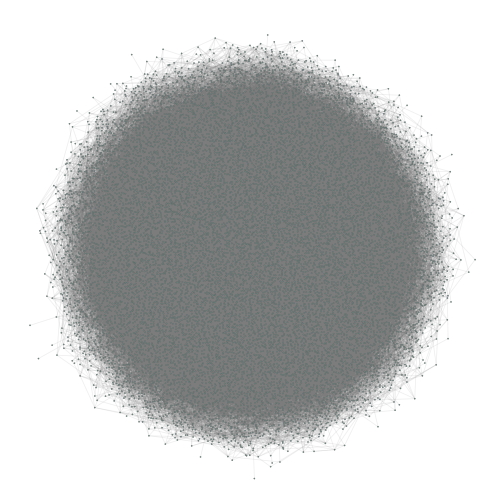

In [6]:
#visualize the plot using netwulf 
nu.draw_netwulf(visualize(random_network)[0])

As the random network has a average degree, k, of 8.181, the random network mirroring the artist collaboration network falls within the supercritical regime as $<k> > 1$. However, it does not satisfy the criteria for it to fall into a connected regime as ln(k) = 9.5. The network resembles one giant component with only 3 isolated nodes.  

The original network depicturing Spotify artists, as well as their collaborations with other artists, will be illustrated below, and compared accordingly.

(<Figure size 480x480 with 1 Axes>, <Axes: >)

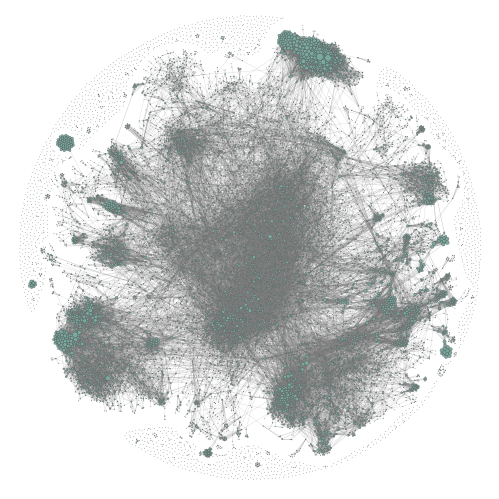

In [7]:
G_SPOTIFY = nx.node_link_graph(json_data)
#remove the "group" attribute from each node because it is not needed for the visualization
for node in G_SPOTIFY.nodes():
    del G_SPOTIFY.nodes[node]["group"]

nu.draw_netwulf(visualize(G_SPOTIFY)[0])

Comparing the Spotify Network with the Random Network, we see a clear difference in how the two networks are clustered. As expected, the random network has no indication of clusters, whereas the Spotify Network has very distinct clusters throughout the network. These clusters represents collaborations either within music genres, geographical communities or other minor factors. This will be elaborated further on in the next analyses. 


Another key difference between the two networks lies in the variation of node-size in the artist collaboration network. The size of each node in both networks is determined by the number of degrees, which in this context is determined by number of collaborations. The size of the nodes in the random network would suggest that the degree of nodes in the network are mostly centered around the average degree of the network, as the all share a similar size. This follows our expectation of the average degree of the random network being centered around $<k>$. 

Contrarily, when observing the artist collaboration network, we see that some nodes clearly distinct themselves in terms of size. In the context of social networks, larger nodes generally tend to suggest the presence of centralized, infuential nodes. In the artist collaboration network, we see that larger nodes are not necessarily indicative of their general influentiality, but more of that within their cluster. 

We will now analyze the degree distribution of the Spotify Network and compare it with its formerly established baseline, the random network. 
To analyze the degree distribution of the random network, we first construct a dictionary. Each key in the dictionary corresponds to a degree ranging from the minimum to the maximum degree observed in the network. The values associated with these keys indicate the frequency of nodes having that particular degree.

Text(0, 0.5, 'p(k)')

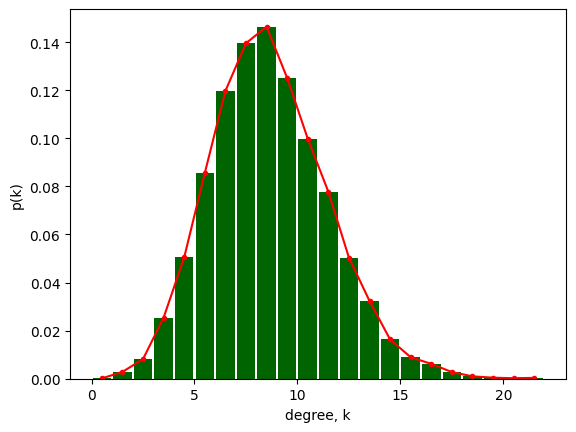

In [9]:
#init random network
G_random = random_network

#construct dict of network
degree_dict = dict(G_random.degree())

#dict values 
degrees = np.array(list(degree_dict.values()))

#compute histogram 
bins = np.linspace(min(degrees),max(degrees),23)
hist, edges = np.histogram(degrees,bins=bins,density=True)
width = bins[1]-bins[0]
x = (edges[1:]+edges[:-1])/2

#plot
fig,ax = plt.subplots()
ax.bar(x, hist, width=width * 0.9, color='#006400')
ax.plot(x,hist,marker=".",color="red")
ax.set_xlabel("degree, k")
ax.set_ylabel("p(k)")

From the above histogram, we see that the nodes of the random network has an average degree centered around $k = 8.181$. The degree distribution of the artist collaboration network is created in the same manner as the random network but using logspace when defining the bins to uncover the potential power-law distribution of the network. We will compare the two below:

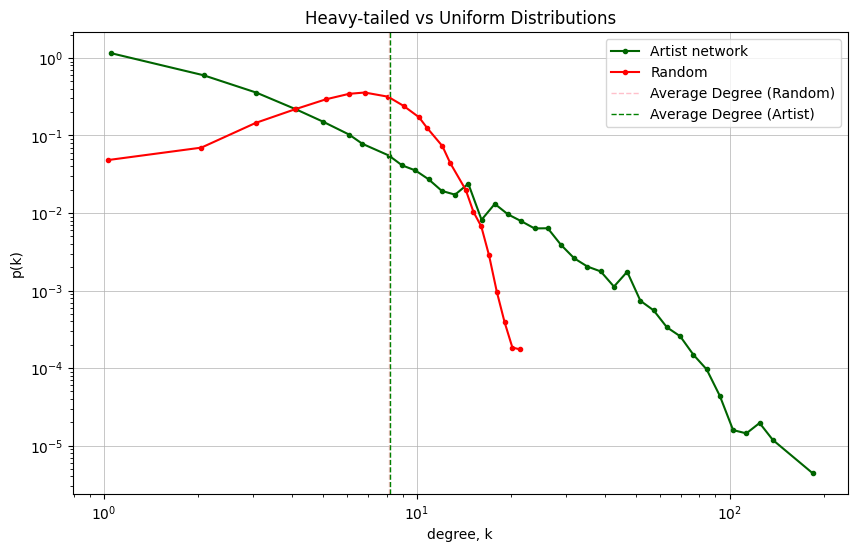

In [34]:
#random (using logspace)
G_random = random_network
degree_dict = dict(G_random.degree())
degrees = np.array(list(degree_dict.values()))
bins_lin = np.logspace(0, np.log10(max(degrees)), 55)
hist_lin, edges_lin = np.histogram(degrees, bins=bins_lin, density=True)
x_lin = (edges_lin[1:] + edges_lin[:-1]) / 2

#Spotify graph  
degree_dict_spotify = dict(G_SPOTIFY.degree())
values = list(degree_dict_spotify.values())
bins_log = np.logspace(0, np.log10(max(values)), 55)
hist_log, edges_log = np.histogram(values, bins=bins_log, density=True)
x_log = (edges_log[1:] + edges_log[:-1]) / 2

xx_log, yy_log = zip(*[(i, j) for (i, j) in zip(x_log, hist_log) if j > 0])
xx_lin, yy_lin = zip(*[(i, j) for (i, j) in zip(x_lin, hist_lin) if j > 0])

#plot
fig, ax = plt.subplots(figsize=(10, 6))

#Spotify lineplot
ax.plot(xx_log, yy_log, marker='o', linestyle='-', color='#006400', markersize = 3, label='Artist network')

#random lineplot 
ax.plot(xx_lin, yy_lin, marker='o', linestyle='-', color='red', markersize = 3, label='Random')

#add average degree 
avg_degree_random = np.mean(degrees)
avg_degree_spotify = np.mean(values)
#median_spotify = np.median(values)

ax.axvline(x=avg_degree_random, color='pink', linestyle='--', linewidth=1, label='Average Degree (Random)')
ax.axvline(x=avg_degree_spotify, color='green', linestyle='--', linewidth=1, label='Average Degree (Artist)')
#ax.axvline(x=median_spotify, color='purple', linestyle='--', linewidth=1, label='Median Degree (Artist)')

# Adding labels and legend
ax.set_title('Heavy-tailed vs Uniform Distributions')
ax.set_xlabel('degree, k')
ax.set_ylabel('p(k)')
ax.set_xscale("log")
ax.set_yscale("log")

ax.grid(True, which="major", linestyle='-', linewidth=0.5)
ax.legend()

# Show plot
plt.show()

Interpretation 

#### 3.1.2 Assortivity <a class="anchor" id="assortivity"></a>

In this part of the analysis, we will have a look at the network's Assortivity Coeffecient for different attributes such as degree and followers. This will be put against a configuration model which randomizes the edges between the nodes.

**1. Configuration model:** To analyze the results of the assortivity coeffecients from the original network, we need to establish a configuration model that randomizes the edges in the network, which could show underlying tendencies or correlations of the original network.

In [7]:
def generate_random_network(graph):
    random_graph = graph.copy()
    max_tries = len(random_graph.edges())
    randomized_graph = nx.double_edge_swap(random_graph, nswap=max_tries*10, max_tries=max_tries*11)
    return randomized_graph

In [9]:
random_graph = generate_random_network(G_SPOTIFY)

In [10]:
average_degree_graph = sum(dict(G_SPOTIFY.degree()).values()) / len(G_SPOTIFY)
average_degree_randomized_graph = sum(dict(random_graph.degree()).values()) / len(random_graph)

print("Average Degree of Graph:", average_degree_graph)
print("Average Degree of Randomized Graph:", average_degree_randomized_graph)

Average Degree of Graph: 8.181431005110733
Average Degree of Randomized Graph: 8.181431005110733


In [12]:
#generate 100 random networks
random_networks = []
for _ in tqdm(range(100)):
    random_network = generate_random_network(G_SPOTIFY)
    random_networks.append(random_network)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [21:32<00:00, 12.93s/it]


**2. "Popularity" Assortivity Coefficient:** We have chosen to use the Popularity attribute, as through multiple iterations it showed more promising results than the Follower attribute. This could be a result of the different ranges of the attributes - "Followers" is unbounded while "Popularity" ranges from 0-1. So, the purpose of this analysis is to highlight if there is a correlation between an artist's popularity and their number of features.

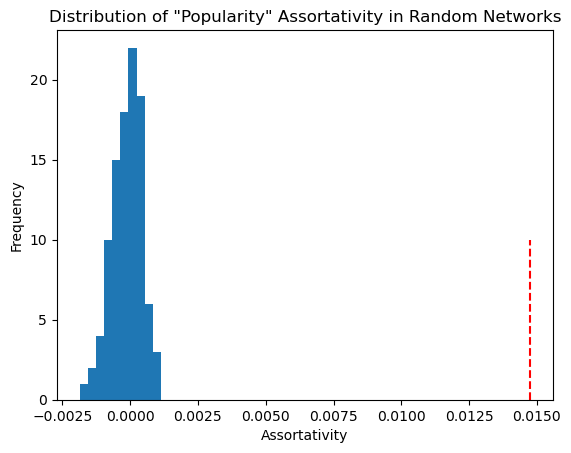

Assortativity of original network: 0.014760978459578364
Mean assortativity of random networks: -0.00011614215022749295
Standard deviation of assortativity in random networks: 0.0005515240265210723


In [17]:
#calculate assortativity for each random network
assortativity_values = []
for random_network in random_networks:
    assortativity = nx.attribute_assortativity_coefficient(random_network, 'popularity')
    assortativity_values.append(assortativity)

#compare assortativity of original network with the distribution
original_assortativity = nx.attribute_assortativity_coefficient(G_SPOTIFY, 'popularity')
mean_assortativity = np.mean(assortativity_values)
std_assortativity = np.std(assortativity_values)

#plot the distribution of assortativity values
plt.hist(assortativity_values)
plt.vlines(original_assortativity, 0, 10, linestyles='dashed', color='red', label='Original Assortativity')
plt.xlabel('Assortativity')
plt.ylabel('Frequency')
plt.title('Distribution of "Popularity" Assortativity in Random Networks')
plt.show()

print(f"Assortativity of original network: {original_assortativity}")
print(f"Mean assortativity of random networks: {mean_assortativity}")
print(f"Standard deviation of assortativity in random networks: {std_assortativity}")

As a main part of the project, we wanted to address if the number of features an artist have had any implications in their popularity. In relation to this, we estimate the Attribute Assortativity Coeffecient for "Popularity". This attribute has been explained earlier, but in short, it can be seen as a good indicator for an artists popularity.  

From the figure, we see that the assortivity coeffecients for the random network is centered around 0 with a mean of $r = -0.00012 \pm 0.00055 $. This is significantly lower than the coeffecient for the Spotify Network, and thus we could conclude that the coeffecient for the original network is not solely derived by chance. 

Although the significant difference between the coefficents of the random networks and the original network, the assortivity coeffecient for the original network is not that high and still close to zero. So, it could be argued that the network shows a very small tendency that nodes with high popularity connects with other nodes that also has a high popularity. But, as the value is so close to zero it hard to derive anything definite.

Moreover, the assortivity coeffecient could be influenced by the many isolated artists that has a high popularity, but have not featured with any other artist in the network.



**3. Degree Assortivity Coefficient:** To analyze the collaboration tendencies of artists we will look into rewieving the degree assortivity coeffecient.

In [14]:
degree_assoritivity_spotify = nx.degree_assortativity_coefficient(G_SPOTIFY)
print("Degree Assortativity of Spotify Network:", degree_assoritivity_spotify)

Degree Assortativity of Spotify Network: 0.36802577022902183


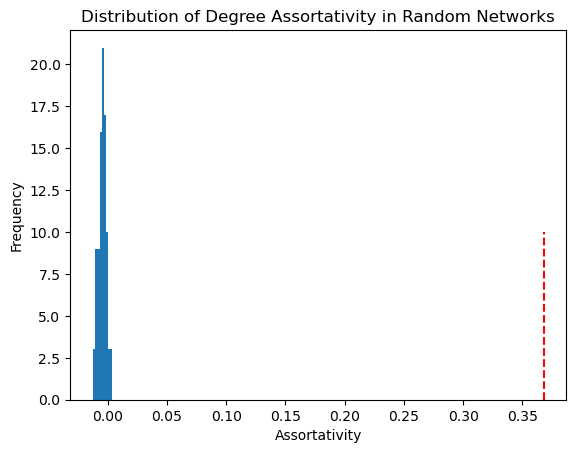

Assortativity of original network: 0.36802577022902183
Mean assortativity of random networks: -0.004657062656354719
Standard deviation of assortativity in random networks: 0.003416786318326021


In [15]:
#calculate assortativity for each random network
assortativity_values = []
for random_network in random_networks:
    assortativity =  nx.degree_assortativity_coefficient(random_network)
    assortativity_values.append(assortativity)

#compare assortativity of original network with the distribution
mean_assortativity = np.mean(assortativity_values)
std_assortativity = np.std(assortativity_values)

#plot the distribution of assortativity values
plt.hist(assortativity_values)
plt.vlines(degree_assoritivity_spotify, 0, 10, linestyles='dashed', color='red', label='Degree Assortativity of Spotify Network')
plt.xlabel('Assortativity')
plt.ylabel('Frequency')
plt.title('Distribution of Degree Assortativity in Random Networks')
plt.show()

print(f"Assortativity of original network: {degree_assoritivity_spotify}")
print(f"Mean assortativity of random networks: {mean_assortativity}")
print(f"Standard deviation of assortativity in random networks: {std_assortativity}")

Social Networks are in their nature assortative, in our case, this also seems to be the case. The Degree Assortativity Coeffecient for the Spotify Network is $r \approx 0.37$, which is well within the threshold for an assortative network. Contrarily, the distribution of the Random Networks is centered around $r = 0$, the mean of the distribution is around $r = -0.0047 \pm 0.0034$. 

In other words, there is a significant difference between the coeffecients of the random networks and the coefficient of the Spotify Network. Leading us to confidently say that the original network is assortative, as we would expect from Social Networks. Because of the significant difference, we could say that the degree assortativity coeffecient is not derived by chance.

Assortative network has high-degree nodes connected with other high-degree nodes, and low-degree nodes connected with other low-degree nodes. In the context of the Spotify Network, this would mean that artists with a lot of features will have tendency to collaborate with other artists that also has many features, and artists with not a lot of features will be more likely to collaborate with other artists that also has few features.

#### 3.1.3 Centrality <a class="anchor" id="centrality"></a>

The Spotify Network is very comprehensive as it contains a lot of different artists from different parts of the world. Therefore it will be an interesting aspect to look into the centrality of different nodes, and who might be the more influentiel or best connected artists.


More specifically, we will look at the closeness centrality. This may reveal factors that dictate what are the most renowed artists in the world of music.

In our research, different centrality estimators were tried, but either the other estimators showed the same results or their estimation focused too much on centrality inside specific communities instead of the network as a whole.

In [16]:
closeness_centralities = nx.closeness_centrality(G_SPOTIFY)
top_5_closeness = sorted(closeness_centralities.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_closeness_artists_for_cent = [artists for artists, _ in top_5_closeness]

In [20]:
print("Top 5 artists according to closeness centrality:")
for artist in top_5_closeness_artists_for_cent:
    print(artist)


Top 5 artists according to closeness centrality:
j balvin
david guetta
diplo
sean paul
tiësto


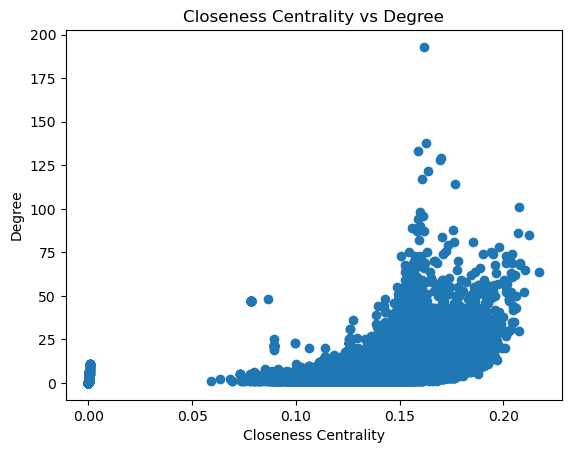

In [19]:
#get the degree and closeness centrality of each node
degrees = dict(G_SPOTIFY.degree())

#create lists to store the degree and closeness centrality values
degree_values = []
closeness_values = []

#iterate over each node and append its degree and closeness centrality to the lists
for node in G_SPOTIFY.nodes():
    degree_values.append(degrees[node])
    closeness_values.append(closeness_centralities[node])


#plot the closeness centrality of nodes vs their degree
plt.scatter(closeness_values, degree_values)
plt.ylabel('Degree')
plt.xlabel('Closeness Centrality')
plt.title('Closeness Centrality vs Degree')
plt.show()


In the figure where Closeness Centrality vs Degree is depictured, it is clear that there is some correlation between the two. However as the highest number of degrees does not result in the highest closeness centrality, there seems to be other factors that result in a higher centrality.

One of the reasons for this could be that many of the high-degree nodes are within the hind/bollywood cluster of the network, however the artists within that cluster does not often collaborate with the west or other artists outside that "niche" community. This may explain why we see that the highest number of degrees does not recieve the highest closeness centrality.

Moreover from the top 5 artists of closeness centrality, we see that there is three renowned producers/DJ's. This is kinda to be expected, as those are the type of artists that usually work together with a plethora of different artists - independent of genres. Therefore it is given that they are central nodes in the network. 

To a surprise, we also see two other artists that are not artists of the type DJ/Producer. These are two very popular artists in their own regard with many monthly listens etc., but they are not the artists with the most listens on Spotify. However, they probably got a high closeness centraility, because they make music in english/spanish, thus appealing to a wider audience. Allowing them to collaborate with artists both within the latin community, but also the english speaking community. Therefore they are much more central for the Spotify Network compared to other artists. 

So, in other words, being able to connect different demographical communities plays a high role in the centrality of the node - maybe more than the degree.

#### 3.1.4 Communities <a class="anchor" id="communities"></a>

As discussed in the degree distribution section of the analysis, we see a clear indication of communities within the network. However, it is rather unsure what constituates these communities. 

(<Figure size 480x480 with 1 Axes>, <Axes: >)

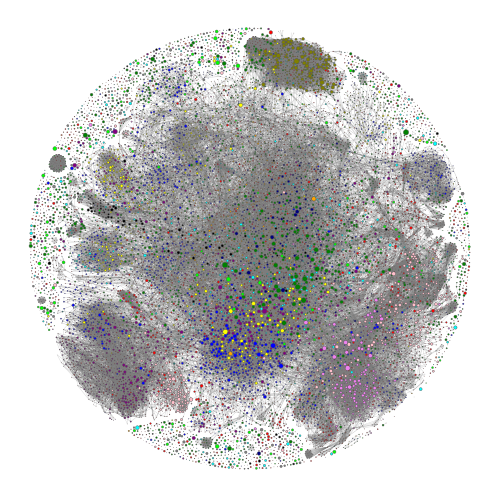

In [24]:
G_SPOTIFY = nx.node_link_graph(json_data)

nu.draw_netwulf(visualize(G_SPOTIFY)[0])

Where the color represents the following groups:

![alt text](legend-1.png)

From the picture, we do get an idea of what constituates to the different communities. An artist's genre does seem to be a factor in what cluster the artist appear within. There is also a indiciation of geographical factors, as many of the latin and hindi artists are collected in their own clusters. These are the most prevalent demographies, but delving more into the network, it could be possible to reveal more clusters that are created mostly because of the nationalities of the artists.

In relation to the aforementioned, as a last element of the analysis  we want to address the communitites of the network. Specfically, we want to evaluate the partitioning made using the genres by comparing it the the Louvain-algorithm. This may highlight how improvements to our rudimentary grouping method could improve our understanding of communities within the world of music.

In relation to aforementioned, we start the analysis by defining our groupings as a partition for the NetworkX package.

In [25]:
group_mapping = {'#FF0000' : ('other',) ,
                '#008000' : ('pop',) ,
                '#0000FF' : ('hip hop',),
                '#FFFF00' : ('pop', 'hip hop'),
                '#800080' :  ('r&b',), 
                '#FFA500' :  ('electronic',),
                '#008080' :  ('undefined',),
                '#00FF00' :  ('rock',), 
                '#FFC0CB' :  ('latin',), 
                '#808080': ('pop', 'rock'),
                '#000080': ('pop', 'electronic'),
                '#800000': ('pop', 'latin'), 
                '#808000': ('hindi/bollywood',),
                '#FF00FF': ('pop', 'indie'),
                '#D2B48C': ('pop', 'r&b'),
                '#00FFFF':  ('indie',),
                '#EE82EE':  ('reggae',),
                '#FF7F50': ('hollywood',),
                '#000000' :  ('country',)                                
}


In [26]:
artists_per_group = {}
for node in G_SPOTIFY.nodes():
    try:
        artists_per_group[G_SPOTIFY.nodes[node]["group"]] += ',,,' + node
    except KeyError:
        artists_per_group[G_SPOTIFY.nodes[node]["group"]] = node
    

In [27]:
partition_of_network = []
for _, values in artists_per_group.items():
    artists = values.split(',,,')

    partition_of_network.append(set(artists))

In [28]:
part = nx.community.louvain_communities(G_SPOTIFY)

In [29]:
mod_genres =  nx.community.modularity(G_SPOTIFY, partition_of_network)
mod_algorithm = nx.community.modularity(G_SPOTIFY,  part)

print("Modularity of partition determined by the genres:" , mod_genres)
print("Modularity of partition determined by algorithm:", mod_algorithm)

Modularity of partition determined by the genres: 0.28448255343183143
Modularity of partition determined by algorithm: 0.843046328145134


To clarify - when there is mention of "Genre Partition", we refer to the groups that was made in the Graph Creation section of the report. On the other hand "Algorithm Partition" refers to the partitioning of the network done by the Louvain-Algorithm.

In [36]:
#generate 100 random networks
random_networks = []
for _ in tqdm(range(100)):
    random_network = generate_random_network(G_SPOTIFY)
    random_networks.append(random_network)

100%|██████████| 100/100 [15:14<00:00,  9.14s/it]


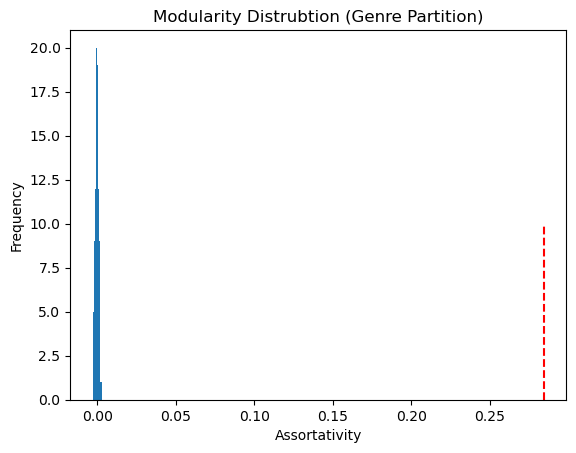

Modularity of original network: 0.28448255343183143 (Genres Partition)
Mean modularity of random networks: -0.00026244064336780615 (Genres Partition)
Standard deviation of modularity in random networks: 0.0011955215904407947 (Genres Partition)


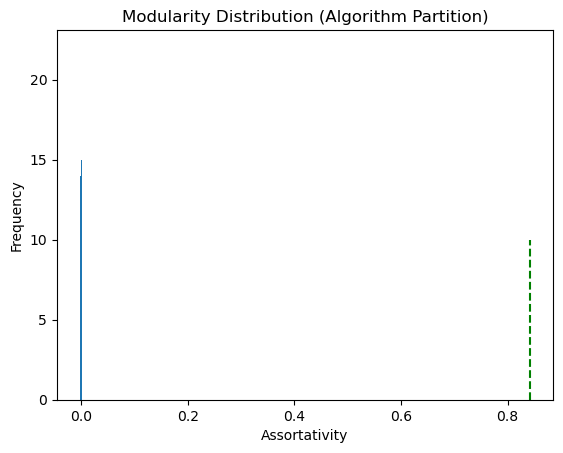

Modularity of original network: 0.843046328145134 (Algorithm Partition)
Mean modularity of random networks: -0.00025798465616624564 (Algorithm Partition)
Standard deviation of modularity in random networks: 0.0011119795797605717 (Algorithm Partition)


In [37]:
#calculate modularity for each random network
modularity_values_genres = []
modularity_values_algorithm = []

for random_network in random_networks:
    mod_genress = nx.community.modularity(random_network, partition_of_network)
    mod_algorithmm = nx.community.modularity(random_network, part)
    modularity_values_genres.append(mod_genress)
    modularity_values_algorithm.append(mod_algorithmm)
    
#compare assortativity of original network with the distribution
mean_modularity_genres = np.mean(modularity_values_genres)
std_modularity_genres = np.std(modularity_values_genres)
mean_modularity_algorithm = np.mean(modularity_values_algorithm)
std_modularity_algorithm = np.std(modularity_values_algorithm)

#plot the distribution of assortativity values
plt.hist(modularity_values_genres)
plt.vlines(mod_genres, 0, 10, linestyles='dashed', color='red', label='Degree Assortativity of Spotify Network')
plt.xlabel('Assortativity')
plt.ylabel('Frequency')
plt.title('Modularity Distrubtion (Genre Partition)')
plt.show()

print(f"Modularity of original network: {mod_genres} (Genres Partition)")
print(f"Mean modularity of random networks: {mean_modularity_genres} (Genres Partition)")
print(f"Standard deviation of modularity in random networks: {std_modularity_genres} (Genres Partition)")

plt.hist(modularity_values_algorithm)
plt.vlines(mod_algorithm, 0, 10, linestyles='dashed', color='green', label='Degree Assortativity of Spotify Network')
plt.xlabel('Assortativity')
plt.ylabel('Frequency')
plt.title('Modularity Distribution (Algorithm Partition)')
plt.show()

print(f"Modularity of original network: {mod_algorithm} (Algorithm Partition)")
print(f"Mean modularity of random networks: {mean_modularity_algorithm} (Algorithm Partition)")
print(f"Standard deviation of modularity in random networks: {std_modularity_algorithm} (Algorithm Partition)")

In both figures it is clearly decpictured that the distrubtions of the modularities for the random networks compared with their respective partitions are centered around 0. For the Genre partition, the mean modularity is $-0.00026 \pm 0.0012$, and the mean modularity for the algorithm partition is $-0.00026 \pm 0.0011$. This is expected, as we expect that the community sturcutre detected of the randomized networks, or "null-models", to be no better than random. 

The partition generated from the artists' genre data enlightens us that there is some correlation between the true partition of the network and the genres that artists are assoicaited with. But as we have earlier learned, the clusters of the network are not solely determined by the genres of the artist. As seen in the analysis of centrality, some of the artists with high centrality had connections between communities that potentially gave them a higher centrality score. Therefore our method of partitioning the network into communities based on the artists' genres is not a bulletproof method. This leads us to believe that to achieve a better partition of the communities, the language or the nationility of the music, which the artists produce, should also be accounted for to achieve a better partitioning of the network.

However, the modularity of the partition is $0.284$, which is still well above $0$, therefore we can not entirely deny that genres has no implications for the clusters in the network. This is also apparent from the plot in the first section.

Moreover, the modularity of the algorithm could also be understood as a max value for the modularity of any given partition, because the Louvain method for community detection simply partition the network in way that maximize the modularity. So, in other words, the Spotify Network can not be perfectly partitioned into communities without any overlaps, where the best modularity found was, as seen by the figure, $0.847$.

This actually puts the genre partition in better light, as we in a sense have addressed that there is no perfect solution for a partition of the Spotify Network - without overlaps. On top of that, a big contributor to a smaller modularity of the genre partition; there is a lot isolated artists, which will be included in the communities of genre partition, but in reality those artists are not connected to network. Therefore, the artists should be treated as their own communities, as they are done by the algorithm partition. Again something that explains the worse modularity of the genre partition.




#### 3.1.4 Conclusion <a class="anchor" id="network_conclusion"></a>

First, the analysis proved that the Spotify Network is significantly different than a randomly generated network. [Insert noget om degree Distribtuion]. 

Afterwards, the assortivity coeffecients of the attribute "Popularity" and degrees were analyzed. Given the analysis, there was found no major indications that popularity was correlated with a higher number of features. However, it seemed that the network was assortative, as the network had a clear tendency to have high-degree nodes connect with high-degree nodes i.e. artists with many features would be more likely to collaborate other artists that had a lot of features. Conversly, artists with few features would also be more likely to collaborate with other artists that also did not have many features. 

Following the assortivity analysis, it was analyzed what factors would be important for an artist to appear as a central node in the Spotify Network. It was found, based on closeness centrality, that artists of the type DJ/Producers were very central, as they inherently collaborate with a lot of different artists. Moreover, artists that were bilingual, i.e. produced music to a wider audience, were also central to the network, as they could connect different communities.

As a last part of the analysis, the communities was directly addressed and it was analysed what consituates them. Here it was found that there was definitely a correlation between genres and the communities, but that a perfect partition could not solely be made based of genres, and a more thorough partition would involve nationalities of the artists. Moreover, it was found with the use of the Louvain method that there is no perfect partition of the network without any overlaps.

Overall, the graph analysis gave many valuable insights into the Spotify Network some of them being expected but also others being unexpected.

### 3.2 Textual Analysis <a class="anchor" id="text_analysis"></a>

## 3.2.1 Motivation for Textual Analysis <a class="anchor" id="motivation_text"></a>

Textual analysis of song lyrics is used in our project to investigate distinctive themes and language patterns across different genres. This approach is interesting for several reasons:

**Genre-Specific Themes**: We would like to see if it is possible to identify genre-specific characteristics/themes. Analyzing these differences should help to define what sets the genres apart.

**Comparative Analysis**: By looking into the frequency and context of words within genres, we can identify which themes and words are predominant for each genre. This analysis helps shed light on what characterises the different genres.

## 3.2.2 Tools, Theory, and Analysis

We begin our analysis by cleaning the dataset, using regular expressions to ensure the text data is ready for analysis. Language detection algorithms identify the primary language of each song's lyrics, which is useful for accurate genre-specific analysis.

We use TF-IDF analysis to highlight distinctive words in each genre’s lyrics, helping to pinpoint unique themes. Additionally, word clouds visually represent these themes, offering an immediate understanding of the most prevalent words across genres. This approach allows us to understand the unique identifiers of the genres and what characterises each genre, some more than others.

### 3.2.3 TF-IDF Analysis Insights

The TF-IDF analysis provides a quantitative look at the words that are most characteristic of the lyrical content within the genres:

For example, for the pop and hip hop genres:

- **Pop Genre**:
  - Key words such as "love," "time," and "feel" are highly prevalent, showing the genre's frequent focus on emotional and relational themes. Other significant words like "baby" and "night" also suggest a focus on personal and intimate experiences, which are central themes in pop music.
- **Hip Hop Genre**:
  - The analysis highlights words like "ain" (from "ain't"), "let," and "fuck," reflecting hip hop's direct and often confrontational lyrical style. This genre also shows a strong presence of confrontational and assertive language with terms like "yo," "bitch," and "want," underlining the expressive and often narrative-driven approach in hip hop lyrics which was also identifiable in the word clouds.

### 3.2.4 Key Insights from Genre-Specific Word Clouds

The word clouds for country, electronic, and hip hop genres distinctly highlight stereotypical and unique themes within each style:

**Country Genre**: Dominated by words like "love," "heart," "girl", and "beer," the word cloud captures country music's fusion of personal emotions with elements of rural life, illustrating its traditional narrative style.
**Electronic Genre**: Features words such as "dance," "night," and "beat," reflecting the genre's core association with nightlife and rhythmic beats, which are central to its popularity at dance venues.
/n
**Hip Hop Genre**: Shows a mix of "love," "money," and slang terms like "bitches" and "gang." This combination highlights hip hop's focus on wealth and street credibility, portraying its cultural depth and the hard realities it often represents.

## 4. Discussion <a class="anchor" id="discussion"></a>

## 5. References <a class="anchor" id="references"></a>